In [1]:
result_csv_filenames = ['lcm_job.csv', 'lcm_job_light.csv', 'lcm_job_complex.csv']

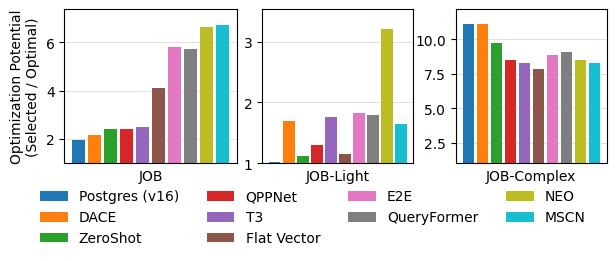

In [6]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import gridspec

model_name_lookup = {
    'dace': 'DACE',
    'flat': 'Flat Vector',
    'neo': 'NEO',
    'postgres': 'Postgres (v16)',
    'qppnet': 'QPPNet',
    't3': 'T3',
    'e2e': 'E2E',
    'mscn': 'MSCN',
    'query_former': 'QueryFormer',
    'zs': 'ZeroShot'
}

ordering = [
    'postgres',
    'dace',
    'zs',
    'qppnet',
    't3',
    'flat',
    'e2e',
    'query_former',
    'neo',
    'mscn',
]

# create subplots with custom width ratios to add more space between plots 2 and 3

fig = plt.figure(figsize=(7, 2))
# Create two GridSpecs: one for the first two plots, one for the third plot
outer_gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2], wspace=0.1)
inner_gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_gs[1], wspace=0.28)

axes = [
    fig.add_subplot(outer_gs[0]),
    fig.add_subplot(inner_gs[0]),
    fig.add_subplot(inner_gs[1])
]

for i, filename in enumerate(result_csv_filenames):
    df = pd.read_csv(
        os.path.join('lcm_result_csvs',
                     filename))

    # remove prefix in column names (e.g. 'join_order_job_eval/')
    df.columns = df.columns.str.replace(r'^.*/', '', regex=True)

    # create a new optimization potential column
    df['optimization_potential'] = df['total_selected_runtime'].astype(float) / df['total_optimal_runtime'].astype(
        float)

    # extract model name
    df['model'] = df['Name'].str.split('-').str[0]

    # sort by ordering list
    df['order_key'] = df['model'].apply(lambda x: ordering.index(x))
    df = df.sort_values(by='order_key', ascending=True)

    # Create a bar plot
    for j, row in enumerate(df.itertuples()):
        model = row.model

        # Use the index as the x-axis value
        axes[i].bar(j, row.optimization_potential, label=model_name_lookup[model])

    if i == 0:
        axes[i].set_ylabel('Optimization Potential\n(Selected / Optimal)')

    if 'job_light' in filename:
        benchmark_name = 'JOB-Light'
    elif 'job_complex' in filename:
        benchmark_name = 'JOB-Complex'
    else:
        benchmark_name = 'JOB'

    axes[i].set_xlabel(benchmark_name)
    axes[i].set_xticks([])

    # set y-min to 1
    axes[i].set_ylim(1, df['optimization_potential'].max() * 1.1)

    if i == 0:
        axes[i].legend(loc='upper right', bbox_to_anchor=(3.1, -0.09), frameon=False, ncols=4)

    axes[i].grid(True, color='lightgrey', linewidth=0.7, alpha=0.7)
    axes[i].set_axisbelow(True)


# save to pdf
plt.show()
fig.savefig('tmp/lcm_optimization_potential.pdf', bbox_inches='tight', dpi=300)

C:\Users\Johannes\AppData\Local\Temp\ipykernel_27636\902069574.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


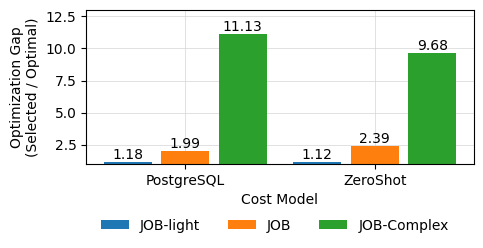

In [ ]:
from collections import defaultdict
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(5, 2))

optim_potential = {
    'PostgreSQL': [('JOB-light', 1.18), ('JOB', 1.99), ('JOB-Complex', 11.13)],
    'ZeroShot': [('JOB-light', 1.12), ('JOB', 2.39), ('JOB-Complex', 9.68)],  # zs
}
num_benchmarks = 3

# change dict to: benchmark -> model -> potential
optim_potential_transposed = defaultdict(dict)
for model, vals in optim_potential.items():
    for benchmark, potential in vals:
        optim_potential_transposed[benchmark][model] = potential

bar_width = 1 / (num_benchmarks + .3)
for i, (benchmark, potential) in enumerate(optim_potential_transposed.items()):
    labels = list(potential.keys())
    potential = list(potential.values())

    bar = ax.bar(np.arange(len(labels)) + i * bar_width, potential, width=bar_width - 0.05, label=benchmark)

    # bar = axs[2].bar(i*0.4,potential, width=bar_width, label=benchmark)
    ax.set_xlabel(f'Cost Model')
    ax.set_ylabel('Optimization Gap\n(Selected / Optimal)')
    ax.set_ylim(bottom=1, top=13)
    ax.set_xticks(np.arange(len(labels)) + bar_width * (len(optim_potential_transposed) - 1) / 2, labels)

    # Add value annotation
    ax.bar_label(bar, labels=[f'{p:.2f}' for p in potential], padding=0)

fig.legend(loc='upper left', bbox_to_anchor=(0.13, -0.1), frameon=False, ncols=3)

# Set light mode background and gridlines
ax.grid(True, color='lightgrey', linewidth=0.7, alpha=0.7)
ax.set_axisbelow(True)
fig.show()
fig.savefig('tmp/optimization_gap_overview.pdf', bbox_inches='tight', dpi=300)
fig.savefig('../graphics/optimization_gap.jpg', bbox_inches='tight', dpi=300)
